In [1]:
# HYBRID LSTM MODEL - PRODUCTION PREDICTION PIPELINE
# Purpose: Back-testing and Real-time Prediction for EMI Payment Default Risk
import pandas as pd
import numpy as np
import joblib
import glob
import os
import sqlalchemy
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ===================================================================================
# GLOBAL CONFIGURATION
# ===================================================================================

# Database Configuration
DB_CONFIG = {
    'host': '10.192.5.43',
    'port': 5432,
    'database': 'postgres',
    'user': 'ml_db',
    'password': 'pass%401234'
}

# Data Configuration
LOS_TABLE_NAME = "Ashirvad"
LOS_START_DATE = '2024-01-01'
LOS_END_DATE = '2024-12-31'
NEW_LMS_FOLDER_PATH = "TestData_Oct2025prediction"

# Model Configuration
MAX_SEQUENCE_LENGTH = 8
ROLLING_WINDOW_SIZE = 3
GRACE_PERIOD_DAYS = 2
PAID_PERCENTAGE_THRESHOLD = 0.90

# Validation Configuration
TARGET_BACKTEST_EMI = 1  # Predict EMI N using data up to EMI N-1

# Status Mapping
TWO_CLASS_STATUS_MAP = {0: 'Paid', 1: 'Not Paid'}
FLAG_ORDER = {'A': 4, 'B': 3, 'C': 2, 'D': 1}

# Feature Definitions (MUST MATCH TRAINING EXACTLY)
SEQUENTIAL_COLS_NUMERICAL = [
    'INSTALLMENT_NO', 'INSTALLMENT_AMOUNT', 'DAYS_LATE', 'DAYS_BETWEEN_DUE_DATES',
    'PAID_RATIO', 'DELTA_DAYS_LATE', 'PAYMENT_SCORE', 'COMPOSITE_RISK',
    'RECENT_PAYMENT_SCORE', 'PAYMENT_SCORE_RANK', 'IS_UNPAID', 'CURRENT_EMI_BEHAVIOR_LABEL'
]

STATIC_COLS_NUMERICAL = ['TOTAL_INCOME', 'TOTAL_EXPENSE', 'LOAN_AMOUNT', 'AGE', 'CYCLE']
STATIC_COLS_OHE = ['MARITAL_STATUS_NAME', 'STATE_NAME', 'LOAN_SCHEDULE_TYPE']
STATIC_EMBEDDING_COLS = ['OCCUPATION_NAME_ENCODED', 'LOAN_PURPOSE_ENCODED']

In [3]:
def load_artifacts():
    """
    Load all required model artifacts. 
    Strict Version: Will raise a FileNotFoundError and stop execution if ANY file is missing.
    """
    # 1. Define required files
    artifact_paths = {
        'preprocessor': 'preprocessor.pkl',
        'model': 'hybrid_lstm_model.h5',
        'mappings': 'embedding_category_mappings.pkl'
    }

    # 2. Pre-check existence for clear reporting
    missing_files = [path for path in artifact_paths.values() if not os.path.exists(path)]
    
    if missing_files:
        print("\n" + "!" * 60)
        print("❌ CRITICAL ERROR: MISSION-CRITICAL ARTIFACTS MISSING")
        print(f"The following required files were not found: {missing_files}")
        print("Pipeline execution halted to prevent incorrect predictions.")
        print("!" * 60 + "\n")
        # Explicitly raise error to stop the script
        raise FileNotFoundError(f"Missing artifacts: {missing_files}")

    # 3. Load artifacts strictly
    try:
        preprocessor = joblib.load(artifact_paths['preprocessor'])
        model = load_model(artifact_paths['model'], compile=False)
        category_mappings = joblib.load(artifact_paths['mappings'])
        
        print("✅ Success: Preprocessor, Model, and Mappings loaded.")
        return preprocessor, model, category_mappings
        
    except Exception as e:
        print(f"❌ ERROR: Artifacts present but failed to load. Check for corruption or version mismatch: {e}")
        raise

In [4]:
# ===================================================================================
# PART 1: LOS DATA LOADING AND PREPROCESSING
# ===================================================================================

def load_and_preprocess_los():
    """
    Loads LOS data from PostgreSQL and applies ALL preprocessing steps 
    exactly as done in training (1_los_data_prep.ipynb).
    """
    conn_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    
    try:
        engine = sqlalchemy.create_engine(conn_string)
        print(f"--- Loading LOS Data from PostgreSQL Table: {LOS_TABLE_NAME} ---")
        
        query = f"""
        SELECT *
        FROM "{LOS_TABLE_NAME}"
        WHERE "LOAN_DATE" BETWEEN '{LOS_START_DATE}' AND '{LOS_END_DATE}';
        """
        df = pd.read_sql_query(query, con=engine)
        print(f"✅ LOS data loaded. Shape: {df.shape}")
        
    except Exception as e:
        print(f"❌ Database connection or query failed: {e}")
        raise
    
    # === EXACT TRAINING PREPROCESSING ===
    
    print("--- Applying LOS Preprocessing (Matching Training) ---")
    
    # 1. Convert PIN_CODE to string
    if 'PIN_CODE' in df.columns:
        df['PIN_CODE'] = df['PIN_CODE'].astype(str)
    
    # 2. Drop columns (matching training)
    columns_to_drop = [
        'CUSTOMER_ID', 'CUSTOMER_NAME', 'BRANCH_ID', 'TEMP_CUST_ID',
        'PHONE1', 'PHONE2', 'HOUSE_NAME', 'LOCALITY', 'STREET',
        'ALT_HOUSE_NAME', 'ALT_LOCALITY', 'ALT_STREET', 'CENTER_ID',
        'ALT_PIN_CODE', 'MARITAL_STATUS', 'LOAN_STATUS',
        'LOAN_STATUS_DESC', 'CLS_DT', 'CIBIL_ID', 'NPA_FLAG',
        'NPA_FROM_DATE', 'NPA_TO_DATE', 'NPA_STATUS',
        'OCCUPATION_ID', 'APPLICATION_ID', 'TENURE_in_months',
        'emi_paid', 'loan_paid_percentage', 'NPA_STATUS_UPDATED',
        'NPA_STATUS_UPDATED_1', 'NPA_STATUS_UPDATED_2', 'YEAR'
    ]
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    # 3. Drop CIBIL_SCORE and CUSTOMER_GRADING_SCORE
    df.drop(columns=['CIBIL_SCORE', 'CUSTOMER_GRADING_SCORE'], inplace=True, errors='ignore')
    
    # 4. Calculate AGE
    df['DATE_OF_BIRTH'] = pd.to_datetime(df['DATE_OF_BIRTH'], errors='coerce')
    df['LOAN_DATE'] = pd.to_datetime(df['LOAN_DATE'], errors='coerce')
    df['AGE'] = (df['LOAN_DATE'] - df['DATE_OF_BIRTH']).dt.days // 365.25
    df.drop(columns=['DATE_OF_BIRTH'], inplace=True)
    
    # 5. Filter CUSTOMER_FLAG (remove 'X' records)
    df = df[df['CUSTOMER_FLAG'] != 'X'].copy()
    
    # 6. Drop high-cardinality columns
    df.drop(columns=['BRANCH_NAME', 'CENTER_NAME'], errors='ignore', inplace=True)
    
    # 7. Impute missing values in numerical columns (USING TRAINING MEDIANS)
    imputation_values = {
        'TOTAL_INCOME': 20000.0,
        'TOTAL_EXPENSE': 1760.0,
        'AGE':  38.0
    }
    
    for col, median_val in imputation_values.items():
        if col in df.columns and df[col].isnull().sum() > 0:
            # Use training median if available, otherwise compute from current data
            #median_val = df[col].median() if col == 'AGE' else default_val
            df[col] = df[col].fillna(median_val)
            print(f"   Imputed {col} with value: {median_val:.2f}")
    
    # 8. Impute OCCUPATION_NAME with 'UNKNOWN'
    if 'OCCUPATION_NAME' in df.columns:
        df['OCCUPATION_NAME'] = df['OCCUPATION_NAME'].fillna('UNKNOWN')
    
    # 9. Consolidate MARITAL_STATUS_NAME
    if 'MARITAL_STATUS_NAME' in df.columns:
        df['MARITAL_STATUS_NAME'] = df['MARITAL_STATUS_NAME'].replace(
            ['UNMARRIED', 'SINGLE'], 'UNMARRIED/SINGLE')
    
    print(f"✅ LOS Preprocessing Complete. Shape: {df.shape}")
    return df

# ===================================================================================
# PART 2: LMS DATA LOADING AND FEATURE ENGINEERING
# ===================================================================================

def load_and_engineer_lms():
    """
    Loads LMS data and applies ALL feature engineering steps 
    exactly as done in training (2_lms_data_prep.ipynb).
    """
    all_lms_dfs = []
    lms_files = sorted(glob.glob(os.path.join(NEW_LMS_FOLDER_PATH, 'test_*.xlsx')))
    
    if not lms_files:
        raise FileNotFoundError(f"No Excel files found matching 'test_*.xlsx' in {NEW_LMS_FOLDER_PATH}.")
    
    print(f"--- Loading {len(lms_files)} LMS Excel file(s) ---")
    for file_name in lms_files:
        try:
            df = pd.read_excel(file_name)
            all_lms_dfs.append(df)
            print(f"   ✅ Loaded: {os.path.basename(file_name)}")
        except Exception as e:
            print(f"   ❌ Error loading {os.path.basename(file_name)}: {e}")
    
    df_lms = pd.concat(all_lms_dfs, ignore_index=True)
    
    # === EXACT TRAINING FEATURE ENGINEERING ===
    
    print("--- Applying LMS Feature Engineering ---")
    
    # Core Cleaning
    df_lms['DUE_DATE'] = pd.to_datetime(df_lms['DUE_DATE'], errors='coerce')
    df_lms['PAID_DT'] = pd.to_datetime(df_lms['PAID_DT'], errors='coerce')
    df_lms.loc[df_lms['STATUS'] == 1, 'PAID_DT'] = pd.NaT
    df_lms = df_lms.sort_values(by=['LOAN_ID', 'INSTALLMENT_NO']).reset_index(drop=True)
    
    # Remove invalid records
    df_lms = df_lms.loc[~((df_lms['PAID_DT'].isnull()) & (df_lms['STATUS'] != 1))].reset_index(drop=True)
    
    # Core Features
    df_lms['DAYS_LATE'] = (df_lms['PAID_DT'] - df_lms['DUE_DATE']).dt.days
    df_lms['DAYS_BETWEEN_DUE_DATES'] = df_lms.groupby('LOAN_ID')['DUE_DATE'].diff().dt.days
    
    # Repayment Schedule Category
    df_lms['REPAYMENT_SCHEDULE_CAT'] = np.select(
        [
            df_lms['DAYS_BETWEEN_DUE_DATES'].isnull(),
            df_lms['DAYS_BETWEEN_DUE_DATES'].isin([28, 29, 30, 31]),
            df_lms['DAYS_BETWEEN_DUE_DATES'] == 7,
            df_lms['DAYS_BETWEEN_DUE_DATES'] == 14,
            df_lms['DAYS_BETWEEN_DUE_DATES'] == 56
        ],
        ['Initial', 'Monthly', 'Weekly', 'Bi-Weekly', 'Bi-Monthly'],
        default='Other'
    )
    
    # Loan Schedule Type
    has_weekly = df_lms.groupby('LOAN_ID')['REPAYMENT_SCHEDULE_CAT'].transform(
        lambda x: 'Weekly' in x.unique())
    has_monthly = df_lms.groupby('LOAN_ID')['REPAYMENT_SCHEDULE_CAT'].transform(
        lambda x: 'Monthly' in x.unique())
    mode_schedule = df_lms.groupby('LOAN_ID')['REPAYMENT_SCHEDULE_CAT'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else 'Initial')
    df_lms['LOAN_SCHEDULE_TYPE'] = np.where((has_weekly) & (has_monthly), 'Hybrid', mode_schedule)
    
    # Payment Features
    df_lms['IS_UNPAID'] = np.where(df_lms['STATUS'] == 1, 1, 0)
    df_lms['IS_DAYS_LATE_MISSING'] = df_lms['DAYS_LATE'].isna().astype(int)
    df_lms['DAYS_LATE'] = df_lms['DAYS_LATE'].fillna(0)
    df_lms['PAID_RATIO'] = (df_lms['PAID_AMOUNT'] / df_lms['INSTALLMENT_AMOUNT']).clip(upper=1.0)
    df_lms['DELTA_DAYS_LATE'] = df_lms.groupby('LOAN_ID')['DAYS_LATE'].diff().fillna(0)
    
    # CRITICAL: Zero out DELTA_DAYS_LATE for unpaid EMIs (matching training)
    df_lms.loc[df_lms['IS_UNPAID'] == 1, 'DELTA_DAYS_LATE'] = 0
    
    # Current EMI Behavior Label
    conditions_behavior = [
        (df_lms['STATUS'] == 1) |
        ((df_lms['STATUS'] == 0) & (df_lms['DAYS_LATE'] > GRACE_PERIOD_DAYS)) |
        ((df_lms['STATUS'] == 2) & (
            (df_lms['DAYS_LATE'] > GRACE_PERIOD_DAYS) |
            (df_lms['PAID_AMOUNT'] / df_lms['INSTALLMENT_AMOUNT'] < PAID_PERCENTAGE_THRESHOLD)
        )),
        (df_lms['STATUS'] == 0) & (df_lms['DAYS_LATE'] <= GRACE_PERIOD_DAYS),
        (df_lms['STATUS'] == 2) & (df_lms['DAYS_LATE'] <= GRACE_PERIOD_DAYS) &
        (df_lms['PAID_AMOUNT'] / df_lms['INSTALLMENT_AMOUNT'] >= PAID_PERCENTAGE_THRESHOLD)
    ]
    choices_behavior = [1, 0, 0]
    df_lms['CURRENT_EMI_BEHAVIOR_LABEL'] = np.select(
        conditions_behavior, choices_behavior, default=-1).astype(np.int8)
    
    # Composite Risk and Payment Score
    df_lms['REMAINING_EMI_RATIO'] = 1 - df_lms["PAID_RATIO"]
    df_lms['COMPOSITE_RISK'] = df_lms['DAYS_LATE'] + (df_lms['REMAINING_EMI_RATIO'] * 10)
    
    conditions_score = [
        df_lms['IS_UNPAID'] == 1,
        (df_lms['CURRENT_EMI_BEHAVIOR_LABEL'] == 1) & (df_lms['IS_UNPAID'] == 0),
        (df_lms['CURRENT_EMI_BEHAVIOR_LABEL'] == 0) & (df_lms['DAYS_LATE'] > 0) &
        (df_lms['DAYS_LATE'] <= GRACE_PERIOD_DAYS) & (df_lms['IS_UNPAID'] == 0),
        (df_lms['CURRENT_EMI_BEHAVIOR_LABEL'] == 0) & (df_lms['DAYS_LATE'] <= 0) &
        (df_lms['IS_UNPAID'] == 0)
    ]
    
    choices_score = [
        -100,
        np.maximum(0.0, np.minimum(0.30, 0.30 - (df_lms['COMPOSITE_RISK'] * 0.03))),
        1.0 / (1 + df_lms['COMPOSITE_RISK']),
        1.5 + (np.abs(df_lms['DAYS_LATE']) / 10)
    ]
    df_lms['PAYMENT_SCORE'] = np.select(conditions_score, choices_score, default=0).astype(np.float32)
    
    rank_choices = [4, 3, 2, 1]
    df_lms['PAYMENT_SCORE_RANK'] = np.select(conditions_score, rank_choices).astype(np.int8)
    
    # === VALIDATION MODE: Extract actual targets before trimming ===
    actual_targets = df_lms.groupby('LOAN_ID').tail(TARGET_BACKTEST_EMI).copy()
    actual_targets = actual_targets[['LOAN_ID', 'CURRENT_EMI_BEHAVIOR_LABEL']].rename(
        columns={'CURRENT_EMI_BEHAVIOR_LABEL': 'ACTUAL_NEXT_EMI_ISSUE'}
    )
    
    print(f"✅ LMS Feature Engineering Complete. Shape: {df_lms.shape}")
    return df_lms, actual_targets

# ===================================================================================
# PART 3: DATA MERGING AND FINAL PREPARATION
# ===================================================================================

def merge_and_finalize_data(df_los, df_lms_full, df_actual_targets, category_mappings):
    """
    Merges LOS and LMS data, applies final feature engineering,
    and performs back-test trimming exactly as in training (3_hybrid_data_prep_optimized.ipynb).
    """
    
    # 1. VALIDATION MODE: Trim the last EMI (EMI N) from sequence
    print(f"\n--- Back-testing Mode: Trimming last {TARGET_BACKTEST_EMI} EMI(s) ---")
    indices_to_drop = df_lms_full.groupby('LOAN_ID').tail(TARGET_BACKTEST_EMI).index
    df_lms = df_lms_full.drop(indices_to_drop).reset_index(drop=True)
    print(f"   LMS records after trimming: {df_lms.shape[0]}")
    
    # 2. Rename LMS columns to avoid conflicts
    RENAME_MAP_LMS = {
        'LOAN_AMOUNT': 'LOAN_AMOUNT_LMS',
        'TENURE': 'TENURE_LMS',
        'INTEREST_RATE': 'INTEREST_RATE_LMS'
    }
    df_lms.rename(columns=RENAME_MAP_LMS, inplace=True)
    
    # 3. Rename LOS columns
    RENAME_MAP_LOS = {
        'LOAN_AMOUNT': 'LOAN_AMOUNT_STATIC',
        'TENURE': 'TENURE_STATIC',
        'INTEREST_RATE': 'INTEREST_RATE_STATIC'
    }
    df_los.rename(columns=RENAME_MAP_LOS, inplace=True)
    
    # 4. Merge
    df_combined = pd.merge(df_los, df_lms, on='LOAN_ID', how='inner', suffixes=('_static', '_lms'))
    print(f"   Combined shape after merge: {df_combined.shape}")
    
    # 5. Clean up column names
    df_combined.rename(columns={
        "LOAN_DATE_static": "LOAN_DATE",
        "LOAN_AMOUNT_STATIC": "LOAN_AMOUNT",
        "TENURE_STATIC": "TENURE",
        "INTEREST_RATE_STATIC": "INTEREST_RATE"
    }, inplace=True)
    
    # 6. Drop unnecessary columns
    cols_to_drop = [
        'LOAN_DATE_lms', 'LOAN_AMOUNT_lms', 'TENURE_lms', 'INTEREST_RATE_lms',
        'DISBURSED_AMOUNT', 'PIN_CODE', 'IS_DAYS_LATE_MISSING', 'STATUS',
        'PAID_DT', 'PAID_AMOUNT', 'REMAINING_EMI_RATIO', 'TENURE', 'INTEREST_RATE'
    ]
    df_combined.drop(columns=[c for c in cols_to_drop if c in df_combined.columns],
                     errors='ignore', inplace=True)
    
    # 7. Impute DAYS_BETWEEN_DUE_DATES
    df_combined["DAYS_BETWEEN_DUE_DATES"].fillna(0, inplace=True)
    
    # 8. Rolling Feature (RECENT_PAYMENT_SCORE) - WITH PROPER SHIFTING
    print("   Creating RECENT_PAYMENT_SCORE (rolling window feature)...")
    df_combined['RECENT_PAYMENT_SCORE'] = df_combined.groupby('LOAN_ID')['PAYMENT_SCORE'].rolling(
        window=ROLLING_WINDOW_SIZE, min_periods=1
    ).mean().reset_index(level=0, drop=True).astype(np.float32)
    
    # CRITICAL: Shift to prevent leakage
    df_combined['RECENT_PAYMENT_SCORE'] = df_combined.groupby('LOAN_ID')['RECENT_PAYMENT_SCORE'].shift(1)
    
    # Use TRAINING mean for imputation
    overall_mean_score = -39.098625  # From training
    df_combined['RECENT_PAYMENT_SCORE'].fillna(overall_mean_score, inplace=True)
    
    # 9. Custom Encoding
    print("   Applying custom encoding for CUSTOMER_FLAG, OCCUPATION_NAME, LOAN_PURPOSE...")
    df_combined['CUSTOMER_FLAG_ENCODED'] = df_combined['CUSTOMER_FLAG'].map(FLAG_ORDER).fillna(0).astype(np.int8)
    
    # Use training category mappings for consistent encoding
    if category_mappings['occupation'] and category_mappings['purpose']:
        occupation_to_code = {v: k+1 for k, v in category_mappings['occupation'].items()}
        purpose_to_code = {v: k+1 for k, v in category_mappings['purpose'].items()}
        
        df_combined['OCCUPATION_NAME_ENCODED'] = df_combined['OCCUPATION_NAME'].astype(str).map(
            occupation_to_code).fillna(0).astype(np.int16)
        df_combined['LOAN_PURPOSE_ENCODED'] = df_combined['LOAN_PURPOSE'].astype(str).map(
            purpose_to_code).fillna(0).astype(np.int16)
        
        print(f"      OCCUPATION_NAME: {df_combined['OCCUPATION_NAME_ENCODED'].nunique()} unique codes")
        print(f"      LOAN_PURPOSE: {df_combined['LOAN_PURPOSE_ENCODED'].nunique()} unique codes")
    else:
        print("   ⚠️ WARNING: Using fallback encoding (may be inconsistent)")
    
    df_combined.drop(columns=['CUSTOMER_FLAG', 'OCCUPATION_NAME', 'LOAN_PURPOSE', 'LOAN_DATE'],
                     errors='ignore', inplace=True)
    
    # 10. OHE Sequential Categorical Feature
    print("   One-hot encoding REPAYMENT_SCHEDULE_CAT...")
    df_combined = pd.get_dummies(df_combined, columns=['REPAYMENT_SCHEDULE_CAT'], prefix='REPAYMENT_CAT')
    
    # 11. Filter for the latest sequence for prediction
    print("   Filtering to keep only necessary sequence (last MAX_SEQUENCE_LENGTH EMIs)...")
    df_combined['SEQUENCE_COUNT'] = df_combined.groupby('LOAN_ID').cumcount() + 1
    df_combined['REVERSE_SEQUENCE_COUNT'] = df_combined.groupby('LOAN_ID')['SEQUENCE_COUNT'].transform(
        'max') - df_combined['SEQUENCE_COUNT']
    df_combined_filtered = df_combined[df_combined['REVERSE_SEQUENCE_COUNT'] < MAX_SEQUENCE_LENGTH].copy()
    df_combined_filtered.drop(columns=['SEQUENCE_COUNT', 'REVERSE_SEQUENCE_COUNT'], inplace=True)
    
    # 12. Merge Actual Target for Validation
    df_combined_filtered = pd.merge(df_combined_filtered, df_actual_targets, on='LOAN_ID', how='left')
    df_combined_filtered['ACTUAL_NEXT_EMI_ISSUE'] = df_combined_filtered.groupby(
        'LOAN_ID')['ACTUAL_NEXT_EMI_ISSUE'].transform('max')
    df_combined_filtered.dropna(subset=['ACTUAL_NEXT_EMI_ISSUE'], inplace=True)
    
    print(f"✅ Data preparation complete. Final shape: {df_combined_filtered.shape}")
    print(f"   Unique loans: {df_combined_filtered['LOAN_ID'].nunique()}")
    
    return df_combined_filtered

# ===================================================================================
# PART 4: PREPROCESSING AND PREDICTION
# ===================================================================================

def preprocess_and_predict(df_full, preprocessor, model):
    """
    Applies preprocessor, reshapes sequences, and runs inference.
    """
    
    print("\n--- Step: Preprocessing and Prediction ---")
    
    # Get expected features from preprocessor
    expected_features = list(preprocessor.feature_names_in_)
    
    # Align DataFrame columns with expected features (safe approach)
    df_aligned = df_full.reindex(columns=expected_features, fill_value=0)
    print(f"   DataFrame aligned to {len(expected_features)} expected features")
    
    # Apply ColumnTransformer
    print("   Applying StandardScaler and OneHotEncoder...")
    X_scaled_ohe = preprocessor.transform(df_aligned)
    ALL_FINAL_COLS = list(preprocessor.get_feature_names_out())
    
    # Reconstruct DataFrame
    X_predict_df = pd.DataFrame(X_scaled_ohe, columns=ALL_FINAL_COLS, index=df_full.index)
    
    # Add back non-transformed columns
    X_predict_df['LOAN_ID'] = df_full['LOAN_ID'].values
    X_predict_df['ACTUAL_NEXT_EMI_ISSUE'] = df_full['ACTUAL_NEXT_EMI_ISSUE'].values
    for col in STATIC_EMBEDDING_COLS:
        X_predict_df[col] = df_full[col].values
    
    # Define input feature sets with correct prefixes
    training_ohe_cols = [c for c in expected_features if c.startswith('REPAYMENT_CAT_')]
    STATIC_COLS_NUMERICAL_FINAL = STATIC_COLS_NUMERICAL + ['CUSTOMER_FLAG_ENCODED']
    
    LSTM_INPUT_COLS_FINAL = [f"num__{c}" for c in SEQUENTIAL_COLS_NUMERICAL] + \
                            [f"num__{c}" for c in training_ohe_cols]
    
    # STATIC_DENSE_COLS_FINAL = [f"num__{c}" for c in STATIC_COLS_NUMERICAL_FINAL] + \
    #                           [c for c in ALL_FINAL_COLS if c.startswith('cat__')]

    STATIC_DENSE_COLS_FINAL = [f"num__{c}" for c in STATIC_COLS_NUMERICAL_FINAL]

    
    print(f"   LSTM input features: {len(LSTM_INPUT_COLS_FINAL)}")
    print(f"   Static dense features: {len(STATIC_DENSE_COLS_FINAL)}")
    print(f"   Embedding features: {len(STATIC_EMBEDDING_COLS)}")
    
    # Sequence Reshaping
    def reshape_for_prediction(X_df, lstm_cols, static_dense_cols, embedding_cols, max_len):
        grouped = X_df.groupby('LOAN_ID')
        loan_ids = list(grouped.groups.keys())
        
        X_lstm = np.zeros((len(loan_ids), max_len, len(lstm_cols)), dtype=np.float32)
        X_static_dense = np.zeros((len(loan_ids), len(static_dense_cols)), dtype=np.float32)
        X_static_embed = np.zeros((len(loan_ids), len(embedding_cols)), dtype=np.int16)
        y_actual = np.zeros((len(loan_ids),), dtype=np.int8)
        
        for i, loan_id in enumerate(loan_ids):
            loan_data = grouped.get_group(loan_id)
            sequence = loan_data[lstm_cols].values
            
            # Pad or truncate sequence
            if len(sequence) >= max_len:
                X_lstm[i, :, :] = sequence[-max_len:]
            else:
                X_lstm[i, -len(sequence):, :] = sequence
            
            # Get static features from last record
            last_record = loan_data.iloc[-1]
            X_static_dense[i, :] = last_record[static_dense_cols].values
            X_static_embed[i, :] = last_record[embedding_cols].values.astype(np.int16)
            y_actual[i] = last_record['ACTUAL_NEXT_EMI_ISSUE'].astype(np.int8)
        
        return X_lstm, X_static_dense, X_static_embed, loan_ids, y_actual
    
    # Execute reshaping
    print("   Reshaping sequences for model input...")
    X_predict_lstm, X_predict_static_dense, X_predict_static_embed, prediction_loan_ids, y_actual = \
        reshape_for_prediction(X_predict_df, LSTM_INPUT_COLS_FINAL, STATIC_DENSE_COLS_FINAL,
                              STATIC_EMBEDDING_COLS, MAX_SEQUENCE_LENGTH)
    
    print(f"   Reshaped data shapes:")
    print(f"      LSTM: {X_predict_lstm.shape}")
    print(f"      Static Dense: {X_predict_static_dense.shape}")
    print(f"      Embedding: {X_predict_static_embed.shape}")
    
    # Model Inference
    print("\n   Running model inference...")
    prediction_inputs = {
        'lstm_input': X_predict_lstm,
        'static_dense_input': X_predict_static_dense,
        'embedding_input': X_predict_static_embed
    }
    
    y_pred_proba = model.predict(prediction_inputs, verbose=0)[:, 0]
    y_pred_class = (y_pred_proba > 0.5).astype(np.int8)
    print(f"✅ Prediction complete for {len(prediction_loan_ids)} unique loans.")
    return prediction_loan_ids, y_pred_proba, y_pred_class, y_actual

# ===================================================================================
# PART 5: EVALUATION AND REPORTING
# ===================================================================================

def evaluate_performance(y_true, y_pred_class, y_pred_proba):
    """
    Generates a professional performance report for the back-test.
    """
    print("\n" + "="*60)
    print("📈 BACK-TEST PERFORMANCE REPORT")
    print("="*60)
    
    acc = accuracy_score(y_true, y_pred_class)
    cm = confusion_matrix(y_true, y_pred_class)
    
    print(f"Overall Accuracy: {acc:.4f}")
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, 
                       index=['Actual Paid', 'Actual Default'], 
                       columns=['Pred Paid', 'Pred Default']))
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_class, target_names=['Paid (0)', 'Not Paid (1)']))
    
    # Senior insight: Financial models care about the "Cost of False Negatives"
    fn = cm[1, 0]
    print(f"⚠️  Missed Defaults (False Negatives): {fn}")
    print("="*60 + "\n")

# ===================================================================================
# MAIN EXECUTION PIPELINE
# ===================================================================================

if __name__ == "__main__":
    try:
        # 1. Load Model and Artifacts
        preprocessor, model, category_mappings = load_artifacts()

        # 2. Extract Static Data (LOS)
        df_los = load_and_preprocess_los()

        # 3. Extract Sequential Data (LMS)
        df_lms_full, df_actual_targets = load_and_engineer_lms()

        # 4. Merge and Align for Production
        df_final = merge_and_finalize_data(df_los, df_lms_full, df_actual_targets, category_mappings)

        # 5. Inference
        loan_ids, probabilities, classes, actuals = preprocess_and_predict(df_final, preprocessor, model)

        # 6. Performance Evaluation (Back-testing)
        evaluate_performance(actuals, classes, probabilities)

        # 7. Consolidated Results DataFrame
        results_df = pd.DataFrame({
            'LOAN_ID': loan_ids,
            'ACTUAL_VALUE': actuals,
            'PREDICTED_CLASS': classes,
            'DEFAULT_PROBABILITY': probabilities
        })
        
        # Mapping for readability
        results_df['PREDICTED_STATUS'] = results_df['PREDICTED_CLASS'].map(TWO_CLASS_STATUS_MAP)
        results_df['ACTUAL_STATUS'] = results_df['ACTUAL_VALUE'].map(TWO_CLASS_STATUS_MAP)

        # 8. Save results
        output_file = "oct_2025_backtest_results.csv"
        results_df.to_csv(output_file, index=False)
        print(f"✅ Results successfully exported to: {output_file}")
        
    except Exception as e:
        print(f"\n❌ PIPELINE FAILED: {str(e)}")
        import traceback
        traceback.print_exc()


✅ Success: Preprocessor, Model, and Mappings loaded.
--- Loading LOS Data from PostgreSQL Table: Ashirvad ---
✅ LOS data loaded. Shape: (1111834, 52)
--- Applying LOS Preprocessing (Matching Training) ---
   Imputed TOTAL_INCOME with value: 20000.00
   Imputed TOTAL_EXPENSE with value: 1760.00
✅ LOS Preprocessing Complete. Shape: (1095563, 16)
--- Loading 24 LMS Excel file(s) ---
   ✅ Loaded: test_001.xlsx
   ✅ Loaded: test_002.xlsx
   ✅ Loaded: test_003.xlsx
   ✅ Loaded: test_004.xlsx
   ✅ Loaded: test_005.xlsx
   ✅ Loaded: test_006.xlsx
   ✅ Loaded: test_007.xlsx
   ✅ Loaded: test_008.xlsx
   ✅ Loaded: test_009.xlsx
   ✅ Loaded: test_010.xlsx
   ✅ Loaded: test_011.xlsx
   ✅ Loaded: test_012.xlsx
   ✅ Loaded: test_013.xlsx
   ✅ Loaded: test_014.xlsx
   ✅ Loaded: test_015.xlsx
   ✅ Loaded: test_016.xlsx
   ✅ Loaded: test_017.xlsx
   ✅ Loaded: test_018.xlsx
   ✅ Loaded: test_019.xlsx
   ✅ Loaded: test_020.xlsx
   ✅ Loaded: test_021.xlsx
   ✅ Loaded: test_022.xlsx
   ✅ Loaded: test_023.

--- Re-preparing inputs for Feature Importance ---

--- Calculating Importance (this may take a minute) ---


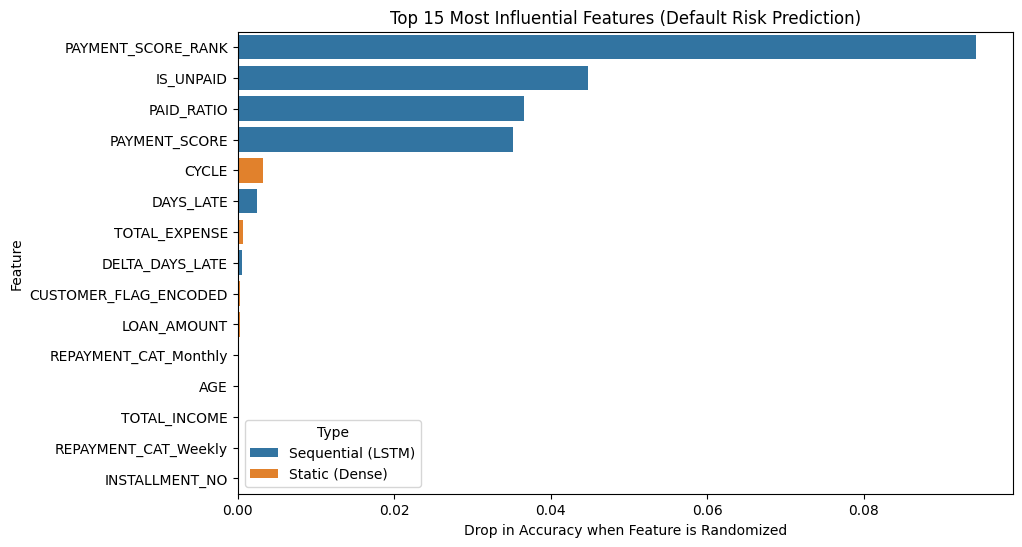

                  Feature  Importance               Type
9      PAYMENT_SCORE_RANK    0.094307  Sequential (LSTM)
10              IS_UNPAID    0.044701  Sequential (LSTM)
4              PAID_RATIO    0.036561  Sequential (LSTM)
6           PAYMENT_SCORE    0.035207  Sequential (LSTM)
21                  CYCLE    0.003170     Static (Dense)
2               DAYS_LATE    0.002498  Sequential (LSTM)
18          TOTAL_EXPENSE    0.000673     Static (Dense)
5         DELTA_DAYS_LATE    0.000546  Sequential (LSTM)
22  CUSTOMER_FLAG_ENCODED    0.000309     Static (Dense)
19            LOAN_AMOUNT    0.000255     Static (Dense)


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import copy

# 1. RE-PREPARE INPUTS (Since they were trapped in function scope)
print("--- Re-preparing inputs for Feature Importance ---")

# Align and Transform df_final using your preprocessor
expected_features = list(preprocessor.feature_names_in_)
df_aligned = df_final.reindex(columns=expected_features, fill_value=0)
X_scaled_ohe = preprocessor.transform(df_aligned)
ALL_FINAL_COLS = list(preprocessor.get_feature_names_out())

# Reconstruct the DataFrame
X_imp_df = pd.DataFrame(X_scaled_ohe, columns=ALL_FINAL_COLS, index=df_final.index)
X_imp_df['LOAN_ID'] = df_final['LOAN_ID'].values
for col in STATIC_EMBEDDING_COLS:
    X_imp_df[col] = df_final[col].values

# Re-define the column lists
training_ohe_cols = [c for c in expected_features if c.startswith('REPAYMENT_CAT_')]
LSTM_COLS = [f"num__{c}" for c in SEQUENTIAL_COLS_NUMERICAL] + [f"num__{c}" for c in training_ohe_cols]
STATIC_DENSE_COLS = [f"num__{c}" for c in STATIC_COLS_NUMERICAL + ['CUSTOMER_FLAG_ENCODED']]

# 2. RESHAPE FUNCTION (Local helper)
def reshape_for_imp(X_df, lstm_cols, static_dense_cols, embedding_cols, max_len):
    grouped = X_df.groupby('LOAN_ID')
    loan_ids = list(grouped.groups.keys())
    X_lstm = np.zeros((len(loan_ids), max_len, len(lstm_cols)), dtype=np.float32)
    X_static_dense = np.zeros((len(loan_ids), len(static_dense_cols)), dtype=np.float32)
    X_static_embed = np.zeros((len(loan_ids), len(embedding_cols)), dtype=np.int16)
    
    for i, loan_id in enumerate(loan_ids):
        loan_data = grouped.get_group(loan_id)
        sequence = loan_data[lstm_cols].values
        if len(sequence) >= max_len:
            X_lstm[i, :, :] = sequence[-max_len:]
        else:
            X_lstm[i, -len(sequence):, :] = sequence
        last_record = loan_data.iloc[-1]
        X_static_dense[i, :] = last_record[static_dense_cols].values
        X_static_embed[i, :] = last_record[embedding_cols].values
    return {'lstm_input': X_lstm, 'static_dense_input': X_static_dense, 'embedding_input': X_static_embed}

# Create the dictionary needed for the model
global_prediction_inputs = reshape_for_imp(X_imp_df, LSTM_COLS, STATIC_DENSE_COLS, STATIC_EMBEDDING_COLS, MAX_SEQUENCE_LENGTH)

# 3. CALCULATE PERMUTATION IMPORTANCE
def calculate_permutation_importance(model, inputs_dict, y_true, lstm_cols, static_cols, embed_cols):
    print("\n--- Calculating Importance (this may take a minute) ---")
    baseline_preds = (model.predict(inputs_dict, verbose=0)[:, 0] > 0.5).astype(int)
    baseline_acc = accuracy_score(y_true, baseline_preds)
    
    importance_results = []

    # LSTM Features
    for i, col in enumerate(lstm_cols):
        X_shuffled = {k: v.copy() for k, v in inputs_dict.items()}
        # Shuffle temporal data
        feat_vals = X_shuffled['lstm_input'][:, :, i].flatten()
        np.random.shuffle(feat_vals)
        X_shuffled['lstm_input'][:, :, i] = feat_vals.reshape(X_shuffled['lstm_input'].shape[0], -1)
        
        shuffled_acc = accuracy_score(y_true, (model.predict(X_shuffled, verbose=0)[:, 0] > 0.5).astype(int))
        importance_results.append({'Feature': col.replace('num__', ''), 'Importance': max(0, baseline_acc - shuffled_acc), 'Type': 'Sequential (LSTM)'})

    # Static Features
    for i, col in enumerate(static_cols):
        X_shuffled = {k: v.copy() for k, v in inputs_dict.items()}
        np.random.shuffle(X_shuffled['static_dense_input'][:, i])
        shuffled_acc = accuracy_score(y_true, (model.predict(X_shuffled, verbose=0)[:, 0] > 0.5).astype(int))
        importance_results.append({'Feature': col.replace('num__', ''), 'Importance': max(0, baseline_acc - shuffled_acc), 'Type': 'Static (Dense)'})

    return pd.DataFrame(importance_results).sort_values(by='Importance', ascending=False)

# Execute
importance_df = calculate_permutation_importance(model, global_prediction_inputs, actuals, LSTM_COLS, STATIC_DENSE_COLS, STATIC_EMBEDDING_COLS)

# 4. VISUALIZE
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Type', data=importance_df.head(15))
plt.title('Top 15 Most Influential Features (Default Risk Prediction)')
plt.xlabel('Drop in Accuracy when Feature is Randomized')
plt.show()

print(importance_df.head(10))